# In conda env openAI
#sudo -H pip install python=3.5  
#sudo -H pip install tensorflow==1.3  
Also Kernel should be openAI  

In [1]:
%%bash
pwd

/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym


# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [3]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [4]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], \
                                          name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 31.0 Training loss: 1.1336 Explore P: 0.9969
Episode: 2 Total reward: 56.0 Training loss: 1.0566 Explore P: 0.9914
Episode: 3 Total reward: 31.0 Training loss: 1.0755 Explore P: 0.9884
Episode: 4 Total reward: 22.0 Training loss: 1.1408 Explore P: 0.9862
Episode: 5 Total reward: 26.0 Training loss: 1.0530 Explore P: 0.9837
Episode: 6 Total reward: 16.0 Training loss: 1.0998 Explore P: 0.9821
Episode: 7 Total reward: 33.0 Training loss: 1.0975 Explore P: 0.9789
Episode: 8 Total reward: 52.0 Training loss: 1.0742 Explore P: 0.9739
Episode: 9 Total reward: 20.0 Training loss: 1.0625 Explore P: 0.9720
Episode: 10 Total reward: 31.0 Training loss: 1.2108 Explore P: 0.9690
Episode: 11 Total reward: 47.0 Training loss: 1.0890 Explore P: 0.9645
Episode: 12 Total reward: 10.0 Training loss: 1.2381 Explore P: 0.9636
Episode: 13 Total reward: 32.0 Training loss: 1.3163 Explore P: 0.9605
Episode: 14 Total reward: 19.0 Training loss: 1.0309 Explore P: 0.9587
Episode: 15 Tot

Episode: 115 Total reward: 19.0 Training loss: 150.7352 Explore P: 0.7756
Episode: 116 Total reward: 8.0 Training loss: 158.0875 Explore P: 0.7749
Episode: 117 Total reward: 24.0 Training loss: 117.2614 Explore P: 0.7731
Episode: 118 Total reward: 8.0 Training loss: 147.2529 Explore P: 0.7725
Episode: 119 Total reward: 21.0 Training loss: 170.5463 Explore P: 0.7709
Episode: 120 Total reward: 25.0 Training loss: 121.8112 Explore P: 0.7690
Episode: 121 Total reward: 8.0 Training loss: 136.6019 Explore P: 0.7684
Episode: 122 Total reward: 11.0 Training loss: 135.4133 Explore P: 0.7676
Episode: 123 Total reward: 24.0 Training loss: 17195.9199 Explore P: 0.7657
Episode: 124 Total reward: 10.0 Training loss: 140.5972 Explore P: 0.7650
Episode: 125 Total reward: 28.0 Training loss: 99.6012 Explore P: 0.7629
Episode: 126 Total reward: 19.0 Training loss: 114.5515 Explore P: 0.7615
Episode: 127 Total reward: 9.0 Training loss: 160.3778 Explore P: 0.7608
Episode: 128 Total reward: 10.0 Training 

Episode: 227 Total reward: 17.0 Training loss: 2536.1643 Explore P: 0.6287
Episode: 228 Total reward: 14.0 Training loss: 3055.9155 Explore P: 0.6278
Episode: 229 Total reward: 21.0 Training loss: 3600.8188 Explore P: 0.6265
Episode: 230 Total reward: 34.0 Training loss: 2178.9675 Explore P: 0.6244
Episode: 231 Total reward: 19.0 Training loss: 8.2447 Explore P: 0.6233
Episode: 232 Total reward: 38.0 Training loss: 1734.4548 Explore P: 0.6209
Episode: 233 Total reward: 17.0 Training loss: 1192.4335 Explore P: 0.6199
Episode: 234 Total reward: 25.0 Training loss: 1959.9935 Explore P: 0.6184
Episode: 235 Total reward: 18.0 Training loss: 2580.2327 Explore P: 0.6173
Episode: 236 Total reward: 16.0 Training loss: 1340.3333 Explore P: 0.6163
Episode: 237 Total reward: 28.0 Training loss: 11.0779 Explore P: 0.6146
Episode: 238 Total reward: 15.0 Training loss: 3158.1431 Explore P: 0.6137
Episode: 239 Total reward: 22.0 Training loss: 5.9163 Explore P: 0.6124
Episode: 240 Total reward: 23.0 T

Episode: 340 Total reward: 14.0 Training loss: 12.8044 Explore P: 0.5206
Episode: 341 Total reward: 14.0 Training loss: 984.1576 Explore P: 0.5198
Episode: 342 Total reward: 11.0 Training loss: 11.8259 Explore P: 0.5193
Episode: 343 Total reward: 8.0 Training loss: 645.4559 Explore P: 0.5189
Episode: 344 Total reward: 12.0 Training loss: 396.2121 Explore P: 0.5183
Episode: 345 Total reward: 15.0 Training loss: 12.1033 Explore P: 0.5175
Episode: 346 Total reward: 11.0 Training loss: 2260.5591 Explore P: 0.5169
Episode: 347 Total reward: 26.0 Training loss: 10.2991 Explore P: 0.5156
Episode: 348 Total reward: 11.0 Training loss: 8.6716 Explore P: 0.5151
Episode: 349 Total reward: 18.0 Training loss: 13.4752 Explore P: 0.5142
Episode: 350 Total reward: 18.0 Training loss: 2264.0474 Explore P: 0.5133
Episode: 351 Total reward: 14.0 Training loss: 22.1365 Explore P: 0.5126
Episode: 352 Total reward: 16.0 Training loss: 14249.8379 Explore P: 0.5118
Episode: 353 Total reward: 16.0 Training lo

Episode: 452 Total reward: 27.0 Training loss: 5.2918 Explore P: 0.4365
Episode: 453 Total reward: 18.0 Training loss: 329.4759 Explore P: 0.4358
Episode: 454 Total reward: 19.0 Training loss: 543.0585 Explore P: 0.4350
Episode: 455 Total reward: 14.0 Training loss: 7.8573 Explore P: 0.4344
Episode: 456 Total reward: 23.0 Training loss: 454.1478 Explore P: 0.4334
Episode: 457 Total reward: 13.0 Training loss: 547.3274 Explore P: 0.4328
Episode: 458 Total reward: 12.0 Training loss: 8.0125 Explore P: 0.4323
Episode: 459 Total reward: 11.0 Training loss: 4.8602 Explore P: 0.4319
Episode: 460 Total reward: 13.0 Training loss: 464.1033 Explore P: 0.4313
Episode: 461 Total reward: 32.0 Training loss: 241.1246 Explore P: 0.4300
Episode: 462 Total reward: 14.0 Training loss: 4.9168 Explore P: 0.4294
Episode: 463 Total reward: 14.0 Training loss: 611.6248 Explore P: 0.4288
Episode: 464 Total reward: 14.0 Training loss: 216.0107 Explore P: 0.4282
Episode: 465 Total reward: 14.0 Training loss: 5

Episode: 564 Total reward: 45.0 Training loss: 3.0455 Explore P: 0.3423
Episode: 565 Total reward: 21.0 Training loss: 4.7239 Explore P: 0.3416
Episode: 566 Total reward: 44.0 Training loss: 3.7766 Explore P: 0.3402
Episode: 567 Total reward: 19.0 Training loss: 3.9122 Explore P: 0.3395
Episode: 568 Total reward: 66.0 Training loss: 212.2846 Explore P: 0.3374
Episode: 569 Total reward: 103.0 Training loss: 33.8501 Explore P: 0.3340
Episode: 570 Total reward: 37.0 Training loss: 184.0299 Explore P: 0.3328
Episode: 571 Total reward: 19.0 Training loss: 77.5866 Explore P: 0.3322
Episode: 572 Total reward: 20.0 Training loss: 4.6995 Explore P: 0.3316
Episode: 573 Total reward: 40.0 Training loss: 6.0328 Explore P: 0.3303
Episode: 574 Total reward: 81.0 Training loss: 5.1123 Explore P: 0.3277
Episode: 575 Total reward: 27.0 Training loss: 9.3883 Explore P: 0.3268
Episode: 576 Total reward: 30.0 Training loss: 78.4735 Explore P: 0.3259
Episode: 577 Total reward: 45.0 Training loss: 65.8872 E

Episode: 677 Total reward: 26.0 Training loss: 176.0338 Explore P: 0.2215
Episode: 678 Total reward: 24.0 Training loss: 9.4650 Explore P: 0.2210
Episode: 679 Total reward: 38.0 Training loss: 4.7542 Explore P: 0.2202
Episode: 680 Total reward: 27.0 Training loss: 2.9297 Explore P: 0.2196
Episode: 681 Total reward: 40.0 Training loss: 10.8870 Explore P: 0.2188
Episode: 682 Total reward: 28.0 Training loss: 53.3684 Explore P: 0.2182
Episode: 683 Total reward: 36.0 Training loss: 5.0648 Explore P: 0.2174
Episode: 684 Total reward: 39.0 Training loss: 3.7231 Explore P: 0.2166
Episode: 685 Total reward: 31.0 Training loss: 5.1630 Explore P: 0.2160
Episode: 686 Total reward: 35.0 Training loss: 6.6538 Explore P: 0.2153
Episode: 687 Total reward: 35.0 Training loss: 6.6423 Explore P: 0.2145
Episode: 688 Total reward: 37.0 Training loss: 22.5066 Explore P: 0.2138
Episode: 689 Total reward: 29.0 Training loss: 49.0416 Explore P: 0.2132
Episode: 690 Total reward: 24.0 Training loss: 23.6996 Exp

Episode: 791 Total reward: 42.0 Training loss: 2.8949 Explore P: 0.1444
Episode: 792 Total reward: 33.0 Training loss: 5.4970 Explore P: 0.1440
Episode: 793 Total reward: 51.0 Training loss: 1.3554 Explore P: 0.1433
Episode: 794 Total reward: 43.0 Training loss: 0.7841 Explore P: 0.1427
Episode: 795 Total reward: 53.0 Training loss: 1.3484 Explore P: 0.1420
Episode: 796 Total reward: 121.0 Training loss: 1.7600 Explore P: 0.1404
Episode: 797 Total reward: 86.0 Training loss: 36.7660 Explore P: 0.1393
Episode: 798 Total reward: 38.0 Training loss: 1.2794 Explore P: 0.1388
Episode: 799 Total reward: 43.0 Training loss: 0.9256 Explore P: 0.1383
Episode: 800 Total reward: 92.0 Training loss: 0.5621 Explore P: 0.1371
Episode: 801 Total reward: 118.0 Training loss: 0.6442 Explore P: 0.1356
Episode: 802 Total reward: 52.0 Training loss: 8.5783 Explore P: 0.1349
Episode: 803 Total reward: 63.0 Training loss: 1.4115 Explore P: 0.1342
Episode: 804 Total reward: 83.0 Training loss: 1.7019 Explore

Episode: 905 Total reward: 72.0 Training loss: 1.0481 Explore P: 0.0708
Episode: 906 Total reward: 74.0 Training loss: 1173.4460 Explore P: 0.0704
Episode: 907 Total reward: 80.0 Training loss: 2661.2258 Explore P: 0.0699
Episode: 908 Total reward: 66.0 Training loss: 0.9100 Explore P: 0.0695
Episode: 909 Total reward: 85.0 Training loss: 0.4980 Explore P: 0.0690
Episode: 910 Total reward: 166.0 Training loss: 0.7316 Explore P: 0.0680
Episode: 911 Total reward: 68.0 Training loss: 0.8067 Explore P: 0.0676
Episode: 912 Total reward: 74.0 Training loss: 0.5365 Explore P: 0.0672
Episode: 913 Total reward: 60.0 Training loss: 0.4750 Explore P: 0.0669
Episode: 914 Total reward: 168.0 Training loss: 0.5685 Explore P: 0.0659
Episode: 915 Total reward: 149.0 Training loss: 0.2931 Explore P: 0.0651
Episode: 916 Total reward: 89.0 Training loss: 0.4645 Explore P: 0.0646
Episode: 917 Total reward: 93.0 Training loss: 0.5246 Explore P: 0.0641
Episode: 918 Total reward: 104.0 Training loss: 1.4856 

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

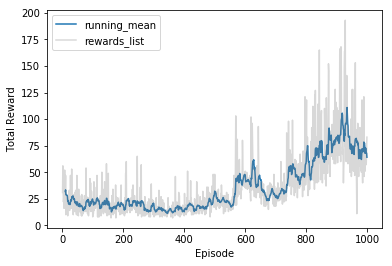

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews, label='running_mean')
plt.plot(eps, rews, color='grey', alpha=0.3, label='rewards_list')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.